<CENTER>
    <a href="http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html" class="icons"><img src="../images/ATLASOD.gif" style="width:40%"></a>
</CENTER>

# Searching the Graviton

This notebook provides the analysis of the Graviton decaying into two Z bosons. This analysis implement two main cuts, which are applied in the lepton type and lepton charge of the four leptons in the final state. At the end of this analysis, you will be able to get a normalized plot with the mass of the four lepton system, being able to compare data and MC sample. Here you can find many tools to preform the desired selection of events, how to declarate histograms, variables, read ROOT files and so on. 

Our analysis requires that the final state contains 4 leptons, which can be put in pairs with opposite charges and same flavours. That means we will expect two pairs of electrons, muons or one pair of electrons and one pair of muons such as the Feynman Diagram shows below: 

$G \rightarrow ZZ \rightarrow e^{+} e^{-} e^{+} e^{-}$ | $G \rightarrow ZZ \rightarrow \mu^{+} \mu^{-} \mu^{+} \mu^{-}$ |$G \rightarrow ZZ \rightarrow e^{+} e^{-} \mu^{+} \mu^{-}$
:-------------------------:|:-------------------------:|:-------------------------:
![Gravitational Lensing Diagram](images/Dark_Matter/GravLensingCaltech.png)  |  ![Gravitational Lensing Photo](images/Dark_Matter/A_Horseshoe_Einstein_Ring_from_Hubble.png) |  ![Gravitational Lensing Photo](images/Dark_Matter/A_Horseshoe_Einstein_Ring_from_Hubble.png)

The first step is to load some basic libraries of c++:

In [1]:
#include <TChain.h>
#include <vector>
#include <TFile.h>
#include <iostream>
#include <string>
#include <stdio.h>
#include <fstream>

The data we want to use to perform our analysis can be found in [folder 4 lep](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/). Here you will see the data and MC samples that corresponds to 4 leptons in the final state. We also define a variable named lumi, which represents the luminosity and it is equal to 10 $fb^{-1}$. If we want to run the analyisis over a fraction of the whole data and MC samples, we can define another variable named fraction, which will be defined equal to 1.0 as default. However, you can change this fraction value and see how this can affect the final result shown in the final plot:

In [1]:
float lumi = 10.;
float fraction = 1.0;
TString path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/";  

Next, we define some chains which will be representing the main groups of background and the data in our analysis. These chains will contain the information storaged in the trees named "mini" in each ROOT file. Basically, there is a main group of backgrounds that we have to take into account:

* z_ttbar: This background contains the Z going to ee, mumu and the ttbar decaying in the leptonic channel MC samples.
* ttbar_v: This background contains the ttbar decaying into W bosons, ee and mumu MC samples.  
* zz: This background contains the diboson ZZ decaying into 4 leptons.
* graviton_signal: This contains the signal we want to search.

In the following code lines you will see how to add ROOT files to a TChain and also, you will see the number of entries in each chain of samples.

In [4]:
TChain *data_chain = new TChain("mini");

data_chain->AddFile(path+"Data/data_A.4lep.root");
data_chain->AddFile(path+"Data/data_B.4lep.root");
data_chain->AddFile(path+"Data/data_C.4lep.root");
data_chain->AddFile(path+"Data/data_D.4lep.root");

int data_entries = (Int_t)data_chain->GetEntries();
cout << data_entries << endl;

832


In [5]:
TChain *z_ttbar_chain = new TChain("mini");

z_ttbar_chain->AddFile(path+"MC/mc_361106.Zee.4lep.root"); //898 entries
z_ttbar_chain->AddFile(path+"MC/mc_361107.Zmumu.4lep.root"); //684 entries
z_ttbar_chain->AddFile(path+"MC/mc_410000.ttbar_lep.4lep.root"); //1031 entries

int z_ttbar_entries = (Int_t)z_ttbar_chain->GetEntries();
cout << z_ttbar_entries << endl;

2613


In [6]:
TChain *ttbar_v_chain = new TChain("mini");

ttbar_v_chain->AddFile(path+"MC/mc_410155.ttW.4lep.root"); // 1373 entries
ttbar_v_chain->AddFile(path+"MC/mc_410218.ttee.4lep.root"); // 32092 entries
ttbar_v_chain->AddFile(path+"MC/mc_410219.ttmumu.4lep.root"); // 26639

int ttbar_v_entries = (Int_t)ttbar_v_chain->GetEntries();
cout << ttbar_v_entries << endl;

60104


In [7]:
TChain *zz_chain = new TChain("mini");

zz_chain->AddFile(path+"MC/mc_363490.llll.4lep.root"); // 554279 entries

int zz_entries = (Int_t)zz_chain->GetEntries();
cout << zz_entries << endl;

554279


In [8]:
TChain *graviton_chain = new TChain("mini");

graviton_chain->AddFile(path+"MC/mc_307434.RS_G_ZZ_llll_c10_m0500.4lep.root"); // 6496 entries

int graviton_entries = (Int_t)graviton_chain->GetEntries();
cout << graviton_entries << endl;

6496


In order to save the information storaged in the ROOT files, we define all variables we are going to use in the next code line:

In [9]:
Float_t         mcWeight;
Float_t         scaleFactor_PILEUP;
Float_t         scaleFactor_ELE;
Float_t         scaleFactor_MUON;
Float_t         scaleFactor_LepTRIGGER;
Bool_t          trigE;
Bool_t          trigM;
UInt_t          lep_n;
vector<float>   *lep_pt;
vector<float>   *lep_eta;
vector<float>   *lep_phi;
vector<float>   *lep_E;
vector<float>   *lep_z0;
vector<int>     *lep_charge;
vector<unsigned int> *lep_type;
vector<bool>    *lep_isTightID;
vector<float>   *lep_ptcone30;
vector<float>   *lep_etcone20;
vector<float>   *lep_trackd0pvunbiased;
vector<float>   *lep_tracksigd0pvunbiased;
Float_t         met_et;
Float_t         met_phi;
UInt_t          jet_n;
vector<float>   *jet_pt;
vector<float>   *jet_eta;
vector<float>   *jet_phi;
vector<float>   *jet_E;
vector<float>   *jet_jvt;
vector<float>   *jet_MV2c10;

For all chains we use, we have to rewrite the variables defined previously, so we create a function that receive the name of the chain. This function rewrites the variables we previously defined above.

In [10]:
void set_branch_address(TString name_sample)
{
    TChain *name_chain = new TChain();
    if(name_sample == "data"){
        name_chain = data_chain;
    }
    if(name_sample == "z_ttbar"){
        name_chain = z_ttbar_chain;
    }
    if(name_sample == "ttbar_v"){
        name_chain = ttbar_v_chain;
    }    
    if(name_sample == "zz"){
        name_chain = zz_chain;
    }    
    if(name_sample == "graviton"){
        name_chain = graviton_chain;
    }
    
    name_chain->SetBranchAddress("trigE", &trigE); 
    name_chain->SetBranchAddress("trigM", &trigM); 
    name_chain->SetBranchAddress("lep_isTightID", &lep_isTightID); 
    name_chain->SetBranchAddress("lep_pt", &lep_pt); 
    name_chain->SetBranchAddress("lep_eta", &lep_eta); 
    name_chain->SetBranchAddress("lep_phi", &lep_phi); 
    name_chain->SetBranchAddress("lep_E", &lep_E); 
    name_chain->SetBranchAddress("lep_n", &lep_n); 
    name_chain->SetBranchAddress("lep_type", &lep_type); 
    name_chain->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
    name_chain->SetBranchAddress("lep_etcone20", &lep_etcone20);
    name_chain->SetBranchAddress("lep_trackd0pvunbiased", &lep_trackd0pvunbiased); 
    name_chain->SetBranchAddress("lep_tracksigd0pvunbiased", &lep_tracksigd0pvunbiased); 
    name_chain->SetBranchAddress("lep_z0", &lep_z0); 
    name_chain->SetBranchAddress("lep_type", &lep_type); 
    name_chain->SetBranchAddress("lep_charge", &lep_charge); 
    name_chain->SetBranchAddress("met_et", &met_et); 
    name_chain->SetBranchAddress("jet_n", &jet_n);
    name_chain->SetBranchAddress("jet_pt", &jet_pt); 
    name_chain->SetBranchAddress("jet_eta", &jet_eta);
    name_chain->SetBranchAddress("jet_jvt", &jet_jvt); 
    name_chain->SetBranchAddress("jet_MV2c10", &jet_MV2c10); 
    
    name_chain->SetBranchAddress("mcWeight", &mcWeight); 
    name_chain->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP); 
    name_chain->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE); 
    name_chain->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON); 
    name_chain->SetBranchAddress("scaleFactor_LepTRIGGER", &scaleFactor_LepTRIGGER); 
    
}

We can start by defining the histograms we are going to fill with the mass of the four lepton system for data and MC samples.

In [11]:
//data samples
TH1F *data_hist_mllll = new TH1F("data_hist_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events", 30, 130, 1230);

//mc samples
TH1F *mc_hist_mllll = new TH1F("mc_hist_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events", 30, 130, 1230);

Now, we define a function named "fill histograms", which will fill the invariant mass of the four lepton system depending on the name of the chain in order to separate Data and MC histograms.

In [12]:
void fill_histograms(TString name_sample, float weight, float mllll)
{
    if(name_sample == "data"){
        data_hist_mllll->Fill(mllll, weight);
    }
    if(name_sample == "z_ttbar"){
        z_ttbar_hist_mllll->Fill(mllll, weight);
        mc_hist_mllll->Fill(mllll, weight);
    }
    if(name_sample == "ttbar_v"){
        ttbar_v_hist_mllll->Fill(mllll, weight);
        mc_hist_mllll->Fill(mllll, weight);
    }
    if(name_sample == "zz"){
        zz_hist_mllll->Fill(mllll, weight);
        mc_hist_mllll->Fill(mllll, weight);
    }   
    if(name_sample == "graviton")
    {
        graviton_hist_mllll->Fill(mllll, weight);
        mc_hist_mllll->Fill(mllll, weight);
    }
}

Now, we define a function that computes the factor weight due to the information in the samples.txt file. Altough this proccess was done manually, you could edit it in order to read information for the sample.txt automatically by using the library fstream. We didn't use it in order to save time for the analysis. If you need to add samples, you will have to look for their information in the samples.txt file.

In [13]:
void get_xsec_weight(vector<float> &xsec_weight)
{
    // sample - xsec - red_eff - sumw - nevt; look for the sample.txt if you add a sample to the analysis
    float xsec=0, red_eff=0, sumw=0; 
        
    //z_ttbar
         
    //Zee		1950.5295		1		150277594200		79045597
    xsec=1950.5295, red_eff=1.0, sumw=150277594200;
    xsec_weight[0] = xsec/(red_eff*sumw);

    //Zmumu		1950.6321		1		147334691090		77497800
    xsec=1950.6321, red_eff=1.0, sumw=147334691090;
    xsec_weight[1] = xsec/(red_eff*sumw);
        
    //ttbar_lep		452.693559		1		49386600		49386600
    xsec=452.693559, red_eff=1.0, sumw=49386600;
    xsec_weight[2] = xsec/(red_eff*sumw);
 
    //ttbar_v
    
    //ttW		0.60084912		1		4075279.75386		None
    xsec=0.60084912, red_eff=1.0, sumw=4075279.75386;
    xsec_weight[3] = xsec/(red_eff*sumw);
        
    //ttee		0.0412888		1		51968.9384584		None
    xsec=0.0412888, red_eff=1.0, sumw=51968.9384584;
    xsec_weight[4] = xsec/(red_eff*sumw);
    
    //ttmumu		0.04129216		1		52007.5311319		None
    xsec=0.04129216, red_eff=1.0, sumw=52007.5311319;
    xsec_weight[5] = xsec/(red_eff*sumw);
        
    //zz
    
    //llll		1.2578		1		7538705.8077		17825300
    xsec=1.2578, red_eff=1.0, sumw=7538705.8077;
    xsec_weight[6] = xsec/(red_eff*sumw);
        
    //graviton
    
    //RS_G_ZZ_llll_c10_m0500		0.02373		1		27000		27000
    xsec=0.02373, red_eff=1.0, sumw=27000;
    xsec_weight[7] = xsec/(red_eff*sumw); 
}

Now, we could 

In [14]:
TString getfilename(TString name_chain, unsigned int ii)
{
    float nbytes = 0;
    TString namefile;
    
    if(name_chain=="z_ttbar"){
    
        nbytes = z_ttbar_chain->GetEntry(ii);
        TFile *file_sample = z_ttbar_chain->GetFile();
        TTree *tree = (TTree*) file_sample->Get("mini");
        
        if(tree->GetEntries()==898){
            namefile = "Zee";
            //cout << "File Zee" << endl;
        }
        if(tree->GetEntries()==684){
            namefile = "Zmumu";
            //cout << "File Zmumu" << endl;
        }        
        if(tree->GetEntries()==1031){
            namefile = "ttbar_lep";
            //cout << "File ttbar lep" << endl;
        }
    }
    
    if(name_chain=="ttbar_v"){
        //weight = 1.0; // Make difference between data and MC
        nbytes = ttbar_v_chain->GetEntry(ii);
        TFile *file_sample = ttbar_v_chain->GetFile();
        TTree *tree = (TTree*) file_sample->Get("mini");
        
        if(tree->GetEntries()==1373){
            namefile = "ttW";
            //cout << "File ttW" << endl;
        }
        if(tree->GetEntries()==32092){
            namefile = "ttee";
            //cout << "File ttee" << endl;
        }        
        if(tree->GetEntries()==26639){
            namefile = "ttmumu";
            //cout << "File ttmumu" << endl;
        }
    }

    if(name_chain=="zz"){
        //weight = 1.0; // Make difference between data and MC
        nbytes = zz_chain->GetEntry(ii);
        TFile *file_sample = zz_chain->GetFile();
        TTree *tree = (TTree*) file_sample->Get("mini");
        
        if(tree->GetEntries()==554279){
            namefile = "llll";
            //cout << "File llll" << endl;
        }
    }
    
    if(name_chain=="graviton"){
        //weight = 1.0; // Make difference between data and MC
        nbytes = graviton_chain->GetEntry(ii);
        TFile *file_sample = graviton_chain->GetFile();
        TTree *tree = (TTree*) file_sample->Get("mini");
        
        if(tree->GetEntries()==6496){
            namefile = "RS_G_ZZ_llll_c10_m0500";
            //cout << "File RS_G_ZZ_llll_c10_m0500" << endl;
        }
    }
    
    return namefile;
}

In [15]:
float calc_weight(TString name_chain, unsigned int entry, float mcWeight, float scaleFactor_PILEUP, 
                  float scaleFactor_ELE, float scaleFactor_MUON, float scaleFactor_LepTRIGGER, vector<float> xsec_w)
{
    float SF = scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER;
    float weight = 0;
    TString namefile = getfilename(name_chain, entry);
    
    if(name_chain=="z_ttbar"){ 
        if(namefile=="Zee"){ weight = xsec_w[0]*mcWeight*SF; } // Zee
        if(namefile=="Zmumu"){ weight = xsec_w[1]*mcWeight*SF; } // Zmumu
        if(namefile=="ttbar_lep"){ weight = xsec_w[2]*mcWeight*SF; } // ttbar lep
    }

    if(name_chain=="ttbar_v"){
        if(namefile=="ttW"){ weight = xsec_w[3]*mcWeight*SF; } // ttW
        if(namefile=="ttee"){ weight = xsec_w[4]*mcWeight*SF; } // ttee
        if(namefile=="ttmumu"){ weight = xsec_w[5]*mcWeight*SF; } // ttmumu
    }
  
    if(name_chain=="zz"){
        if(namefile=="llll"){ weight = xsec_w[6]*mcWeight*SF; } // llll
    }

    if(name_chain=="graviton"){
        if(namefile=="RS_G_ZZ_llll_c10_m0500"){ weight = xsec_w[7]*mcWeight*SF; } // RS_G_ZZ_llll_c10_m0500
    } 
    
    return weight;
}

In [16]:
float calc_mllll(vector<float> lep_pt, vector<float> lep_eta, vector<float> lep_phi, vector<float>lep_E)
{
    float px_0 = lep_pt[0]*TMath::Cos(lep_phi[0]); // x-component of lep[0] momentum
    float py_0 = lep_pt[0]*TMath::Sin(lep_phi[0]); // y-component of lep[0] momentum
    float pz_0 = lep_pt[0]*TMath::SinH(lep_eta[0]); // z-component of lep[0] momentum
    float px_1 = lep_pt[1]*TMath::Cos(lep_phi[1]); // x-component of lep[1] momentum
    float py_1 = lep_pt[1]*TMath::Sin(lep_phi[1]); // y-component of lep[1] momentum
    float pz_1 = lep_pt[1]*TMath::SinH(lep_eta[1]); // z-component of lep[1] momentum
    float px_2 = lep_pt[2]*TMath::Cos(lep_phi[2]); // x-component of lep[2] momentum
    float py_2 = lep_pt[2]*TMath::Sin(lep_phi[2]); // y-component of lep[2] momentum
    float pz_2 = lep_pt[2]*TMath::SinH(lep_eta[2]); // z-component of lep[3] momentum
    float px_3 = lep_pt[3]*TMath::Cos(lep_phi[3]); // x-component of lep[3] momentum
    float py_3 = lep_pt[3]*TMath::Sin(lep_phi[3]); // y-component of lep[3] momentum
    float pz_3 = lep_pt[3]*TMath::SinH(lep_eta[3]); // z-component of lep[3] momentum
    float sumpx = px_0 + px_1 + px_2 + px_3; // x-component of 4-lepton momentum
    float sumpy = py_0 + py_1 + py_2 + py_3; // y-component of 4-lepton momentum
    float sumpz = pz_0 + pz_1 + pz_2 + pz_3; // z-component of 4-lepton momentum
    float sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3]; // energy of 4-lepton system
    return TMath::Sqrt(sumE*sumE - sumpx*sumpx - sumpy*sumpy - sumpz*sumpz)/1000; // /1000 to go from MeV to GeV
}

In [17]:
// cut on lepton charge
// paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
bool cut_lep_charge(vector<int> lep_charge)
{
    // throw away when sum of lepton charges is not equal to 0
    // first lepton is [0], 2nd lepton is [1] etc
    if( lep_charge[0]+lep_charge[1]+lep_charge[2]+lep_charge[3]!=0 ){return false;}
    return true;
}

In [18]:
// cut on lepton type
// paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
bool cut_lep_type(vector<unsigned int> lep_type)
{
    // for an electron lep_type is 11
    // for a muon lep_type is 13
    // throw away when none of eeee, mumumumu, eemumu
    
    float sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3];
    
    if(sum_lep_type!=44 && sum_lep_type!=48 && sum_lep_type!=52){ return false;}
    return true;
}

In [19]:
void analysis_of_samples(TString name_sample, vector<float> xsec_w)
{
    int nbytes = 0;
    int pass = 0;
    
    set_branch_address(name_sample);
    int nentries = 0;
    TChain *new_chain = new TChain();
    float weight = 0;
    float fraction = 1.0;

    if(name_sample == "data"){
        new_chain = data_chain;
        weight = 1.0;
    }
    if(name_sample == "z_ttbar"){
        new_chain = z_ttbar_chain;
    }
    if(name_sample == "ttbar_v"){
        new_chain = ttbar_v_chain;
    }    
    if(name_sample == "zz"){
        new_chain = zz_chain;
    }   
    if(name_sample == "graviton"){
        new_chain = graviton_chain;
    }   
    
    nentries = (Int_t)new_chain->GetEntries();
    cout << "Processing: "+name_sample << endl;

    for(int ii=0; ii<nentries*fraction; ii++)
    {
        nbytes = new_chain->GetEntry(ii);
        
        if(name_sample!="data"){
            //Total weight
            weight = calc_weight(name_sample, ii, mcWeight, scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON, 
                             scaleFactor_LepTRIGGER, xsec_w);
        }
        
        if(cut_lep_charge(*lep_charge)==false) continue;
    
        if(cut_lep_type(*lep_type)==false) continue;
    
        float mllll = 0;
        mllll = calc_mllll(*lep_pt, *lep_eta, *lep_phi, *lep_E);  
        
        fill_histograms(name_sample, weight, mllll);

        pass++;
    }

    cout << "nInt: " << nentries << "\t" << "nOut: " << pass << endl;

}

In [20]:
void graviton_analysis()
{
    vector<float> xsec_w(8); // All elements are zero at the beginning
    get_xsec_weight(xsec_w); // Compute the xsec from samples.txt
    
    vector<TString> name_chains = {"data", "z_ttbar", "ttbar_v", "zz", "graviton"};

    for(int ii=0; ii<name_chains.size(); ii++){
    analysis_of_samples(name_chains[ii], xsec_w);
    }
}

In [21]:
graviton_analysis();

Processing: data
nInt: 832	nOut: 507
Processing: z_ttbar
nInt: 2613	nOut: 834
Processing: ttbar_v
nInt: 60104	nOut: 25102
Processing: zz
nInt: 554279	nOut: 523957
Processing: graviton
nInt: 6496	nOut: 6002


In [22]:
//TCanvas *canvas = new TCanvas();

In [23]:
void plot_histogram(TString name_hist)
{
    TCanvas *canvas = new TCanvas();
    TH1F *data_name_hist = new TH1F();
    TH1F *mc_name_hist = new TH1F();
    
    if(name_hist == "mllll"){
        data_name_hist = data_hist_mllll;
        mc_name_hist = mc_hist_mllll;
    }

    TLegend *leg = new TLegend(0.6, 0.7, 0.85, 0.8); // Declares a legend to the function fit and his position in canvas
    data_name_hist->SetMarkerStyle(20);
    data_name_hist->SetMarkerColor(kBlack);
    data_name_hist->SetStats(0);
    //mc_name_hist->SetFillStyle(3454);
    mc_name_hist->SetFillColorAlpha(kBlue, 0.45);
    mc_name_hist->SetLineColor(kBlue);
    mc_name_hist->SetStats(0);
    mc_name_hist->SetLineWidth(2);

    data_name_hist->DrawNormalized("P");
    mc_name_hist->DrawNormalized("sameH");

    leg->AddEntry(data_name_hist, "Data", "lep");
    leg->AddEntry(mc_name_hist, "MC samples", "l");
    leg->SetBorderSize();
    leg->Draw();
    
    TLatex l;
    l.SetNDC();
    l.SetTextFont(42);
    l.SetTextColor(kBlack);
    l.SetTextSize(0.04);  
    l.DrawLatex(0.55,0.6,"ATLAS Preliminary Open Data");

    TLatex o;
    o.SetNDC();
    o.SetTextFont(42);
    o.SetTextColor(kBlack);
    o.SetTextSize(0.03);
    double dely = 0.04; 
    o.DrawLatex(0.55,0.6-dely, Form("#sqrt{s} = 13 TeV, 10 fb^{-1}"));
    o.DrawLatex(0.55,0.57-dely, Form("G #rightarrow Z Z^{*} #rightarrow l^{+} l^{-} l^{+} l^{-}"));
    
    canvas->Draw();
    canvas->Print("Graviton_mllll_DataMC.pdf");
}

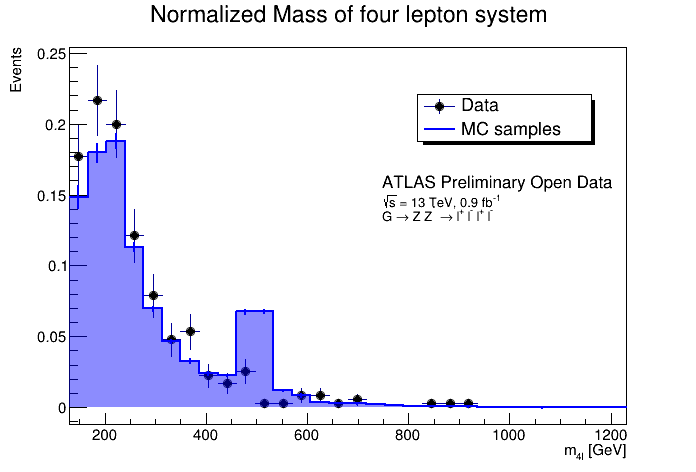

Info in <TCanvas::Print>: pdf file Graviton_mllll_DataMC.pdf has been created


In [24]:
plot_histogram("mllll");